In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import time
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt

%matplotlib notebook
%matplotlib inline

sns.set(style='darkgrid')

In [3]:
X = pd.read_csv('weather.csv')
y = X.RainTomorrow.replace({'No':0, 'Yes': 1})

X['Date'] = pd.to_datetime(X['Date'])
X['Year'] = X['Date'].dt.year
X['Month'] = X['Date'].dt.month
X['Day'] = X['Date'].dt.day

X.drop(columns=['RainTomorrow', 'Unnamed: 0', 'Date'], inplace=True)

X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 24 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Location       142193 non-null  object 
 1   MinTemp        141556 non-null  float64
 2   MaxTemp        141871 non-null  float64
 3   Rainfall       140787 non-null  float64
 4   Evaporation    81350 non-null   float64
 5   Sunshine       74377 non-null   float64
 6   WindGustDir    132863 non-null  object 
 7   WindGustSpeed  132923 non-null  float64
 8   WindDir9am     132180 non-null  object 
 9   WindDir3pm     138415 non-null  object 
 10  WindSpeed9am   140845 non-null  float64
 11  WindSpeed3pm   139563 non-null  float64
 12  Humidity9am    140419 non-null  float64
 13  Humidity3pm    138583 non-null  float64
 14  Pressure9am    128179 non-null  float64
 15  Pressure3pm    128212 non-null  float64
 16  Cloud9am       88536 non-null   float64
 17  Cloud3pm       85099 non-null

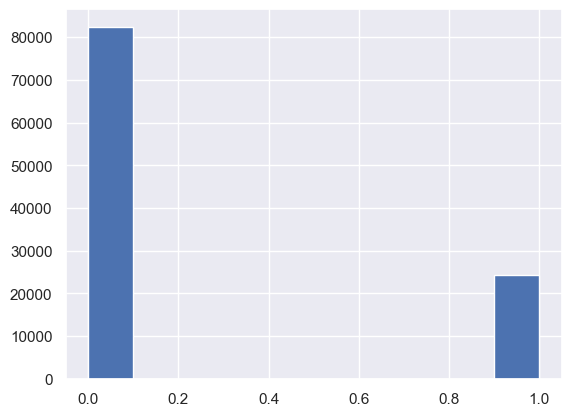

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False, random_state=52)
y_train.hist();

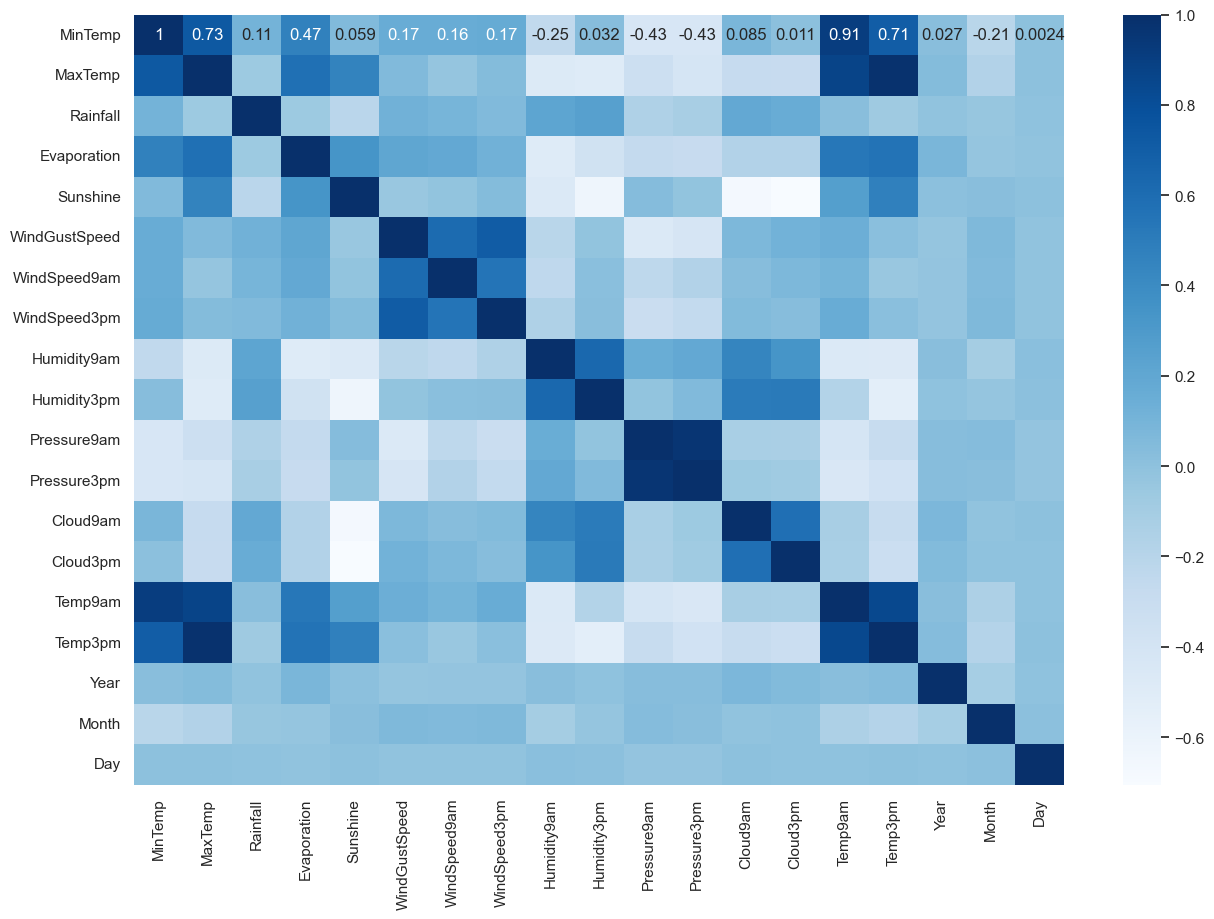

In [5]:
numeric_data = X_train.select_dtypes([np.number])
numeric_data_mean = numeric_data.mean()
numeric_features = numeric_data.columns

X_train = X_train.fillna(numeric_data_mean)
X_test = X_test.fillna(numeric_data_mean)


corr = numeric_data.corr()

plot = sns.heatmap(corr, cmap='Blues', annot=True);
plot.figure.set_size_inches(15, 10)

In [6]:
for col in numeric_features:
    print(f'unique values in {col} - {X_train[col].unique().shape} \n')

unique values in MinTemp - (385,) 

unique values in MaxTemp - (506,) 

unique values in Rainfall - (639,) 

unique values in Evaporation - (351,) 

unique values in Sunshine - (146,) 

unique values in WindGustSpeed - (66,) 

unique values in WindSpeed9am - (44,) 

unique values in WindSpeed3pm - (45,) 

unique values in Humidity9am - (101,) 

unique values in Humidity3pm - (102,) 

unique values in Pressure9am - (509,) 

unique values in Pressure3pm - (506,) 

unique values in Cloud9am - (11,) 

unique values in Cloud3pm - (11,) 

unique values in Temp9am - (431,) 

unique values in Temp3pm - (501,) 

unique values in Year - (11,) 

unique values in Month - (12,) 

unique values in Day - (31,) 



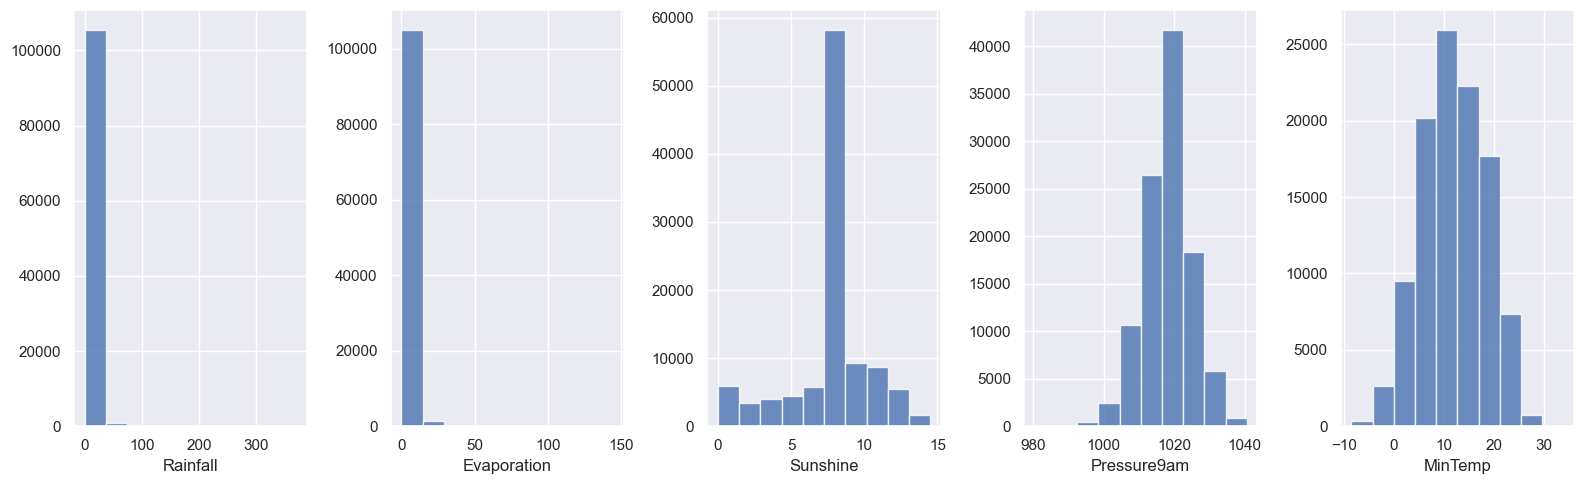

In [7]:
fig, axs = plt.subplots(figsize=(16, 5), ncols=5)
for i, feature in enumerate(['Rainfall', 'Evaporation', 'Sunshine', 'Pressure9am', 'MinTemp']):
    axs[i].hist(X_train[feature], alpha=0.8)
    axs[i].set_xlabel(feature)
plt.tight_layout()

In [8]:
from sklearn.linear_model import LogisticRegression

baseline = LogisticRegression()
baseline.fit(X_train[numeric_features], y_train)
y_pred = baseline.predict(X_test[numeric_features])
y_train_pred = baseline.predict(X_train[numeric_features])

print(f'Test accuracy = {np.sum(y_pred == y_test) / y_test.shape[0] : .2f}')
print(f'Train accuracy = {np.sum(y_train_pred == y_train) / y_train.shape[0] : .2f}')

Test accuracy =  0.85
Train accuracy =  0.84


In [9]:
print(f'Test accuracy with best_constant = {np.sum(np.zeros(y_test.shape) == y_test) / y_test.shape[0] : .2f}')
print(f'Train accuracy with best_constant = {np.sum(np.zeros(y_train.shape) == y_train) / y_train.shape[0] : .2f}')

Test accuracy with best_constant =  0.78
Train accuracy with best_constant =  0.77


In [10]:
mean_location = X_train.groupby('Location')[['Sunshine', 'Pressure9am', 'Rainfall']].mean().rename(
    columns = {'Sunshine': 'mean_sunshine', 'Pressure9am': 'mean_pressure9am', 'Rainfall': 'mean_rainfall'})

mean_location
X_train = X_train.merge(mean_location, on = 'Location', how = 'left')
X_test = X_test.merge(mean_location, on = 'Location', how = 'left')

In [11]:
def kde_target(var_name, df):
    
    corr = df['target'].corr(df[var_name])

    avg_rain = df.loc[df['target'] == 0, var_name].median()
    avg_not_rain = df.loc[df['target'] == 1, var_name].median()
    
    plt.figure(figsize = (8, 4))
    
    sns.kdeplot(df.loc[df['target'] == 0, var_name], label = 'target = 0')
    sns.kdeplot(df.loc[df['target'] == 1, var_name], label = 'target = 1')
    
    plt.xlabel(var_name); plt.ylabel('Density'); plt.title(f'{var_name} Distribution')
    plt.legend();
    
    print(f'The correlation between {var_name} and the target is {corr:.2f}')

    print(f'Median value when it did not rain = {avg_not_rain}')
    print(f'Median value when it did rain = {avg_rain} \n')

The correlation between MinTemp and the target is 0.10
Median value when it did not rain = 13.0
Median value when it did rain = 11.6 

The correlation between mean_sunshine and the target is -0.10
Median value when it did not rain = 7.382788308625952
Median value when it did rain = 7.382788308625952 

The correlation between mean_rainfall and the target is 0.10
Median value when it did not rain = 2.162326312888331
Median value when it did rain = 2.1400868296487636 

The correlation between mean_pressure9am and the target is -0.05
Median value when it did not rain = 1018.0876703223662
Median value when it did rain = 1018.2065860043269 



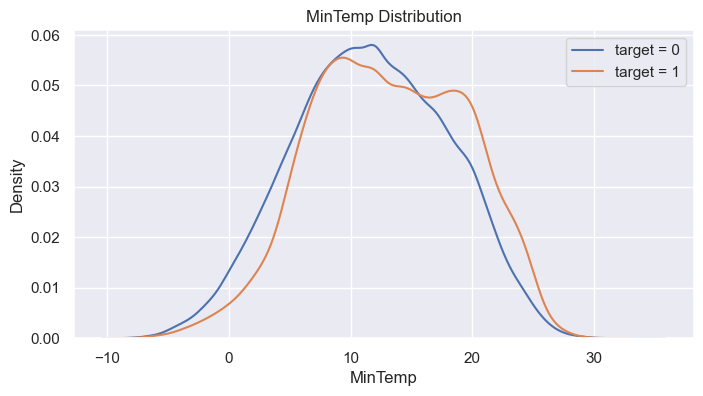

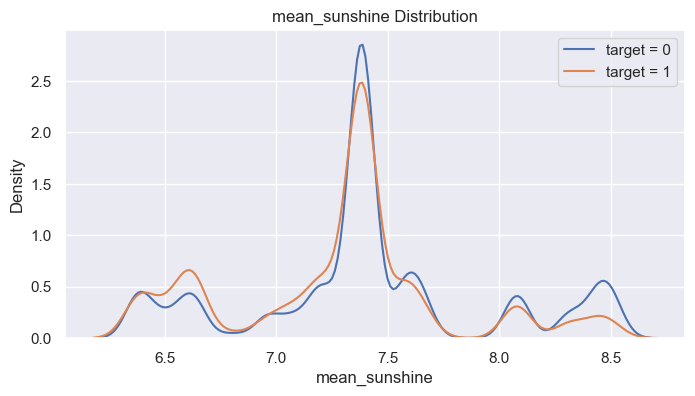

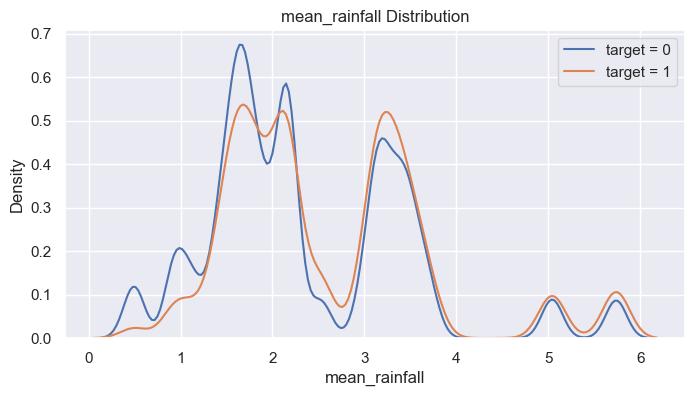

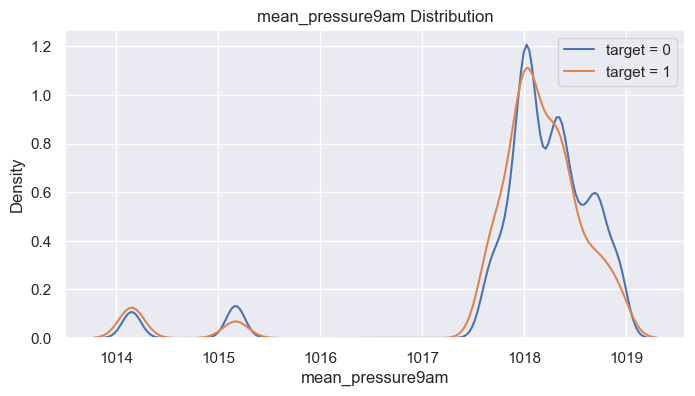

In [12]:
train = X_train.copy(deep=True)
train['target'] = y_train

kde_target('MinTemp', train)
kde_target('mean_sunshine', train)
kde_target('mean_rainfall', train)
kde_target('mean_pressure9am', train)

In [13]:
numeric_data = X_train.select_dtypes([np.number])
numeric_data_mean = numeric_data.mean()
numeric_features = numeric_data.columns

X_test = X_test.fillna(numeric_data_mean)

categorical = list(X_train.dtypes[X_train.dtypes == 'object'].index)

X_train[categorical] = X_train[categorical].fillna('NotGiven')
X_test[categorical] = X_test[categorical].fillna('NotGiven')

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

lr_pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('classification', LogisticRegression())
])

lr_model = lr_pipeline.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)
print(f'Test accuracy {accuracy_score(y_pred, y_test):.2f}')

Test accuracy 0.85


Best C = 137.3823795883264


Text(0, 0.5, 'CV score')

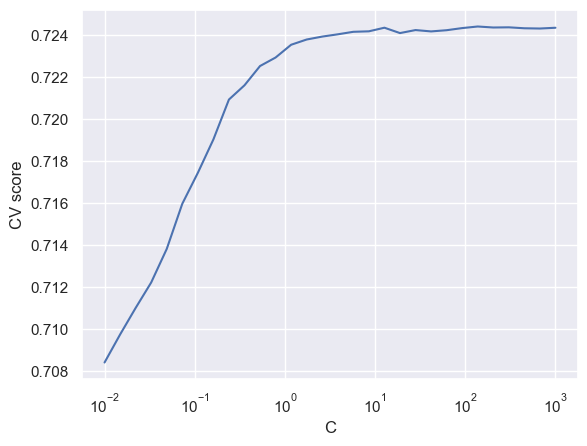

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

C = np.logspace(-2, 3, 30)
searcher = GridSearchCV(lr_pipeline, [{'classification__C': C}], scoring='balanced_accuracy', cv=5)
searcher.fit(X_train, y_train)

best_C = searcher.best_params_['classification__C']
print(f'Best C = {best_C}')

plt.plot(C, searcher.cv_results_['mean_test_score'])
plt.xscale('log')
plt.xlabel('С')
plt.ylabel('CV score');

In [16]:
lr_pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('classification', LogisticRegression(C=best_C))
])

lr_model = lr_pipeline.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)
print(f'Test accuracy {accuracy_score(y_pred, y_test):.2f}')

Test accuracy 0.85


In [17]:
from sklearn.neighbors import KNeighborsClassifier

X_train_transform = column_transformer.fit_transform(X_train)
X_test_transform = column_transformer.transform(X_test)

kn_model = KNeighborsClassifier()
kn_model.fit(X_train_transform, y_train)
y_pred = kn_model.predict(X_test_transform.toarray())
print(f'Test accuracy {accuracy_score(y_pred, y_test):.2f}')

Test accuracy 0.83


100%|███████████████████████████████████████████| 20/20 [14:57<00:00, 44.86s/it]


Best test accuracy 0.8403330614081972 with 33 neighbors


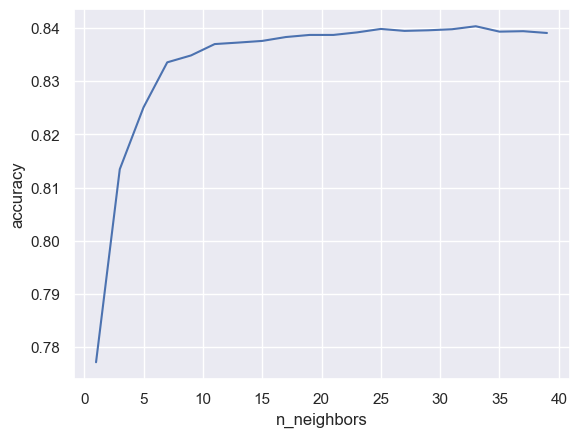

In [29]:
from tqdm import tqdm

n_neighbors = np.arange(1, 40, 2)

max_accuracy = 0
accuracy = []

for n in tqdm(n_neighbors):
    model = KNeighborsClassifier(n_neighbors=n)

    model.fit(X_train_transform, y_train)
    y_pred = model.predict(X_test_transform.toarray())
    acc = accuracy_score(y_pred, y_test)
    accuracy.append(acc)
    
    if acc > max_accuracy:
        max_accuracy = acc
        best_n = n

print(f'Best test accuracy {max_accuracy} with {best_n} neighbors')

plt.plot(n_neighbors, accuracy)
plt.xlabel('n_neighbors')
plt.ylabel('accuracy');

100%|███████████████████████████████████████████| 30/30 [20:11<00:00, 40.38s/it]


Best test accuracy 0.8403330614081972 with h = None


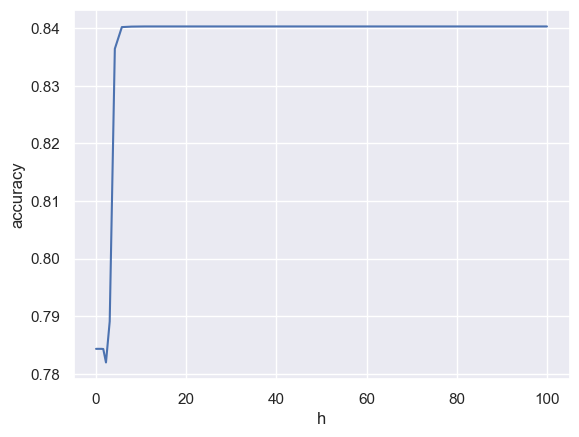

In [31]:
def K(distance, h=0.05):
    ret = np.array(distance)/h
    return (1 - ret**2) * (np.abs(ret) <= 1)
    
h_grid = np.logspace(-2, 2, 30)
accuracy, best_h = [], None

for h in tqdm(h_grid):
    model = KNeighborsClassifier(n_neighbors=best_n, weights=lambda x: K(x, h=h))

    model.fit(X_train_transform, y_train)
    y_pred = model.predict(X_test_transform.toarray())
    acc = accuracy_score(y_pred, y_test)
    accuracy.append(acc)
    
    if acc > max_accuracy:
        max_accuracy = acc
        best_h = h

print(f'Best test accuracy {max_accuracy} with h = {best_h}')

plt.plot(h_grid, accuracy)
plt.xlabel('h')
plt.ylabel('accuracy');

In [28]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
y_pred = gnb.fit(X_train_transform.toarray(), y_train).predict(X_test_transform.toarray())

print(f'Test accuracy {accuracy_score(y_pred, y_test):.2f}')

Test accuracy 0.77


In [84]:
theta = np.array([1, 2, 3])

X =  np.array([[ 1,  1, 1],
               [-1, -2, 1],
               [-1, -2, 2],
               [-2, -2, -3]
              ])

y = np.array([1, 1, 0, 0])

In [110]:
[X[i] @ theta for i in range(X.shape[0])]

[6, -2, 1, -15]

In [85]:
def probability(theta, X):
    result = 1 / (1 + np.exp(-( X @ theta)))
    
    return result
    
prob = probability(theta, X)

assert type(prob) == np.ndarray
assert prob.shape == (X.shape[0],), 'Неверный размер массива'
assert (prob.round(3) == [0.998, 0.119, 0.731, 0.]).all(), 'Функция считается неверно'

In [86]:
def binary_class_prediction(theta, X, threshold =.5):
    prob =  probability(theta, X)
    result = (prob > threshold) * 1
    
    return result

y_pred = binary_class_prediction(theta, X)

assert type(y_pred) == np.ndarray, 'Возвращается неверный тип'
assert y_pred.shape == (X.shape[0],), 'Неверный размер массива'
assert min(y_pred) == 0, 'Функция считается неверно'
assert max(y_pred) == 1, 'Функция считается неверно'

In [114]:
def logloss(theta, X, y): 
    result = -np.sum([y[i] * np.log(probability(theta, X[i])) + (1 - y[i]) * 
                      np.log(1 - probability(theta, X[i])) for i in range(X.shape[0])]) / X.shape[0]
    return result

In [115]:
logloss(theta, X, y)

0.8606664224002997

In [116]:
assert logloss(theta, X, y).round(3) == 0.861, 'Функция считается неверно'

In [117]:
def gradient(theta, X, y):
    result = X.T @ (probability(theta, X) - y) / X.shape[0]

    return result 

assert gradient(theta, X, y).shape == theta.shape, 'Неверный размер массива'

In [118]:
def fit(X, y, batch_size=10, h=0.05,  iters=100, plot=True):

    # получаем размерности матрицы
    size, dim = X.shape

    # случайная начальная инициализация
    theta = np.random.uniform(size=dim)
    
    errors = []
    
    theta_history = theta
    colors = [plt.get_cmap('gist_rainbow')(i) for i in np.linspace(0,1,dim)]
    
    # plt 
    if plot:
        fig = plt.figure(figsize=(15, 10))
        ax1 = fig.add_subplot(221)
        ax2 = fig.add_subplot(222)
        ax3 = fig.add_subplot(212)
        fig.suptitle('Gradient descent')
        
        
    for _ in range(iters):  
        
        # берём случайный набор элементов
        batch = np.random.choice(size, batch_size, replace=False)
        X_batch = X[batch]
        y_batch = y[batch]

        # считаем производные
        grad = gradient(theta, X_batch, y_batch)
        
        assert type(grad) == np.ndarray, 'неверный тип'
        assert len(grad.shape) == 1, 'Необходимо вернуть одномерный вектор'
        assert grad.shape[0] == len(theta), 'длина вектора должна быть равной количеству весов'
        
        
        # Обновляем веса
        
        theta -= grad * h
        
        theta_history = np.vstack((theta_history, theta))
        
        # error
        loss = logloss(theta, X, y)
        errors.append(loss)
        
        if plot:
            ax1.clear()            
            ax1.scatter(range(dim), theta, label='Gradient solution')
            ax1.legend(loc="upper left")
            ax1.set_title('theta')
            ax1.set_ylabel(r'$\bar \beta$')
            ax1.set_xlabel('weight ID')
            
            
            ax2.plot(range(_+1), errors, 'g-')
            ax2.set_title('logloss')
            ax2.set_xlabel('itarations')
            
            ax3.plot(theta_history)
            ax3.set_title('update theta')
            ax3.set_ylabel('value')
            ax3.set_xlabel('itarations')
            time.sleep(0.05)
            fig.canvas.draw()   
            
    return theta